In [1]:
import numpy as np
import pandas as pd
import json
from PIL import Image
import matplotlib.pyplot as plt
import requests
import torch
from transformers import MllamaForConditionalGeneration, AutoProcessor
import os
import glob
from tqdm import trange
from MMObject.llama import Llama32
from MMObject.utls import *
from MMObject.prompt_generator import *
import torch.nn.functional as F

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
val_aokvqa, coco_val_caption, coco_id_filename = prepare_dataset()

In [3]:
base_path = "/home/ubuntu/data/coco/val2017/"

In [4]:
sub_ds = val_aokvqa[:2]

In [5]:

prompt_template = """
You task is to select one of the four following options based on the image and the question. Specifically, you need to output {{0}} or {{1}} or {{2}}or {{3}} surrounded by curly braces as well as rationales of why you chose that option.
The rationales should also include in curly braces the answer to the question.

Here are some examples that you can follow:
{}

Now, it's your turn. Again, remember to put your answer in curly braces. Here is the question you need to answer.
"""
pg0123 = PromptGenerator0123(prompt_template = prompt_template)
prompt_template = pg0123.generate_template(val_aokvqa[:3])

In [6]:
print(prompt_template)


You task is to select one of the four following options based on the image and the question. Specifically, you need to output {0} or {1} or {2}or {3} surrounded by curly braces as well as rationales of why you chose that option.
The rationales should also include in curly braces the answer to the question.

Here are some examples that you can follow:
Question: What is in the motorcyclist's mouth?
Choices: 0. toothpick 1. food 2. popsicle stick 3. cigarette
Rationale: {He's smoking while riding.The motorcyclist has a lit cigarette in his mouth while he rides on the street.The man is smoking.}
Answer: {3}
Question: Which number birthday is probably being celebrated?
Choices: 0. one 1. ten 2. nine 3. thirty
Rationale: {There is a birthday cake on the table with the number 30 written in icing.The cake says 30.The numerals three and zero are written on the cake, which indicates the person is 30 years of age as of the birthdate.}
Answer: {3}
Question: What best describes the pool of water?


In [10]:
"""
You task is to select one of the four following options based on the image and the question. Specifically, you need to output 0 or 1 or 2 or 3 surrounded by curly braces as well as rationales of why you chose that option.
The rationales should also include in curly braces the answer to the question.

Here are some examples that you can follow:
Question: What is in the motorcyclist's mouth?
Choices: 0. toothpick 1. food 2. popsicle stick 3. cigarette
Rationale: Looking at the picture, we can see a man with white shirt riding a motorcycle. Now as we find the motorcyclist in the question, we can see that he has a cigarette in his mouth.
Answer: 3
Question: Which number birthday is probably being celebrated?
Choices: 0. one 1. ten 2. nine 3. thirty
Rationale: From the question, we know that someone is celebrating for the birthday. Looking at the picture, we can see two things on the table top. One is a grey bear which is likely to be a cake, the other is a cake with several candles on it. By looking at the purple cake, we can see it writes number thirty on it.
Answer: 3
Question: What best describes the pool of water?
Choices: 0. frozen 1. fresh 2. dirty 3. boiling
Rationale: Looking at the picture, we can see a tree in the middle. Behind the tree, we can see several giraffes. On the bottom of the picture, we can see a pool of water. This refers to the pool mentioned in the question. The pool is dark brown and it is brown and surrounded with mud. So the pool is dirty.
Answer: 2

Now, it's your turn. Again, remember to put your answer in curly braces. Here is the question you need to answer.
"""

''

In [7]:
val_aokvqa[0]

{'split': 'val',
 'image_id': 461751,
 'question_id': '22jbM6gDxdaMaunuzgrsBB',
 'question': "What is in the motorcyclist's mouth?",
 'choices': ['toothpick', 'food', 'popsicle stick', 'cigarette'],
 'correct_choice_idx': 3,
 'direct_answers': ['cigarette',
  'cigarette',
  'cigarette',
  'cigarette',
  'cigarette',
  'cigarette',
  'cigarette',
  'cigarette',
  'cigarette',
  'cigarette'],
 'difficult_direct_answer': False,
 'rationales': ["He's smoking while riding.",
  'The motorcyclist has a lit cigarette in his mouth while he rides on the street.',
  'The man is smoking.']}

In [10]:
len("000000397133")

12

In [ ]:
"""
He's smoking while riding.The motorcyclist has a lit cigarette in his mouth while he rides on the street.The man is smoking.
Looking at the picture, we can see a man with white shirt riding a motorcycle. Now as we find the motorcyclist in the question, we can see that he has a cigarette in his mouth.

Looking at the picture, we can see a man with white shirt riding a motorcycle. Now as we find the motorcyclist in the question, we can see that he has a cigarette in his mouth.
"""

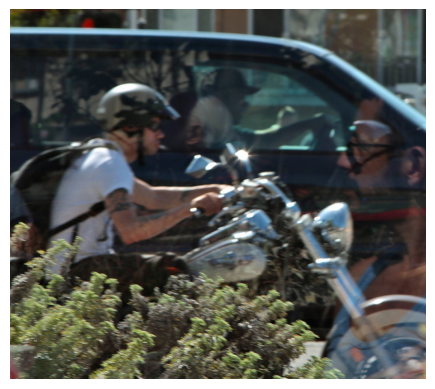

Question: What is in the motorcyclist's mouth?
Choices: 0. toothpick 1. food 2. popsicle stick 3. cigarette
Correct Answer: cigarette
Direct Answers: ['cigarette', 'cigarette', 'cigarette', 'cigarette', 'cigarette', 'cigarette', 'cigarette', 'cigarette', 'cigarette', 'cigarette']
Rationale: ["He's smoking while riding.", 'The motorcyclist has a lit cigarette in his mouth while he rides on the street.', 'The man is smoking.']


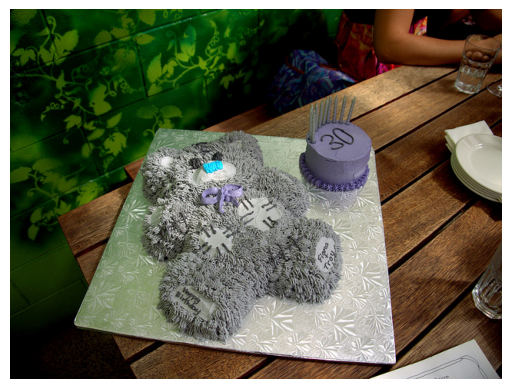

Question: Which number birthday is probably being celebrated?
Choices: 0. one 1. ten 2. nine 3. thirty
Correct Answer: thirty
Direct Answers: ['thirty', '30th', 'thirty', 'thirty', 'thirty', '30th', 'thirty', 'thirty', 'thirty', 'thirty']
Rationale: ['There is a birthday cake on the table with the number 30 written in icing.', 'The cake says 30.', 'The numerals three and zero are written on the cake, which indicates the person is 30 years of age as of the birthdate.']


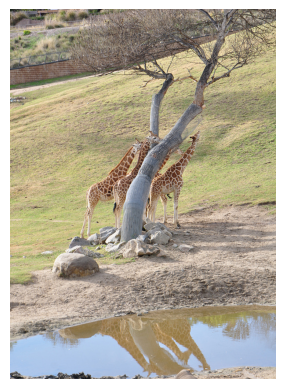

Question: What best describes the pool of water?
Choices: 0. frozen 1. fresh 2. dirty 3. boiling
Correct Answer: dirty
Direct Answers: ['muddy', 'dirty', 'murky water', 'muddy', 'pond', 'pond', 'watering hole', 'pond', 'pond', 'dirty']
Rationale: ['The pool is dark brown.', 'It it brown and surrounded with mud.', 'The pool is dirty.']


In [9]:
for i in range(3):
    demonstrate_example(val_aokvqa[i])

In [11]:
"""
Looking at the picture, we can see a tree in the middle. Behind the tree, we can see several giraffes. On the bottom of the picture, we can see a pool of water. This refers to the pool mentioned in the question. The pool is dark brown and it is brown and surrounded with mud. So the pool is dirty.
"""

''